In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout


In [4]:
# Load the dataset
data = pd.read_csv('AMZN_2006-01-01_to_2018-01-01.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
# Use only the 'Close' price for forecasting
close_data = data[['Close']]

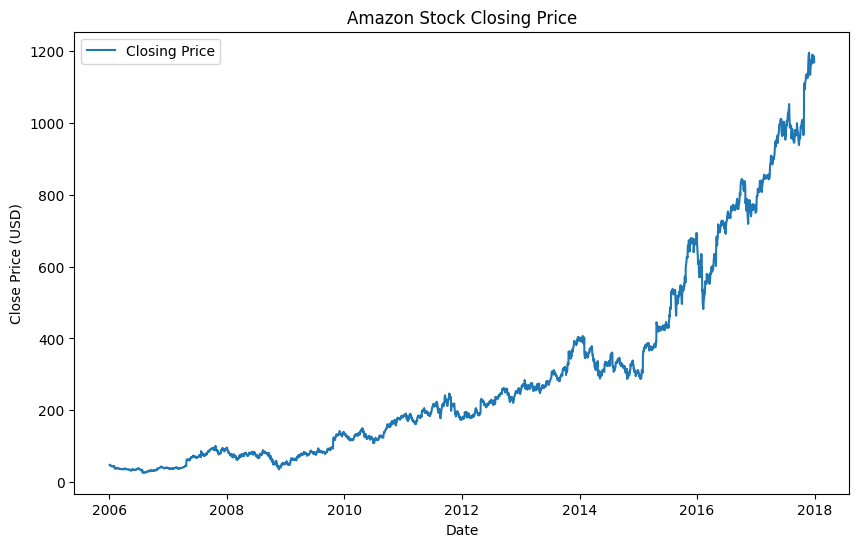

In [5]:
# Plot the closing prices
plt.figure(figsize=(10, 6))
plt.plot(close_data, label='Closing Price')
plt.title('Amazon Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

In [6]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

In [7]:
# Prepare the training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [8]:
# Create sequences for RNN input
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(100, activation='tanh', input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Train the model
model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.6180e-04 - val_loss: 8.4846e-04
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1798e-04 - val_loss: 0.0018
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7375e-04 - val_loss: 6.6986e-04
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6263e-04 - val_loss: 7.8911e-04
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1589e-04 - val_loss: 4.2802e-04
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3379e-04 - val_loss: 3.6421e-04
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.2787e-04 - val_loss: 3.2132e-04
Epoch 9/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.4013e-04 - val_loss: 0.0012
Epoch 10/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4249e-04 - val_loss: 2.0794e-04
Epoch 11/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0993e-04 -

In [11]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [12]:
# Transform back to original scale
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

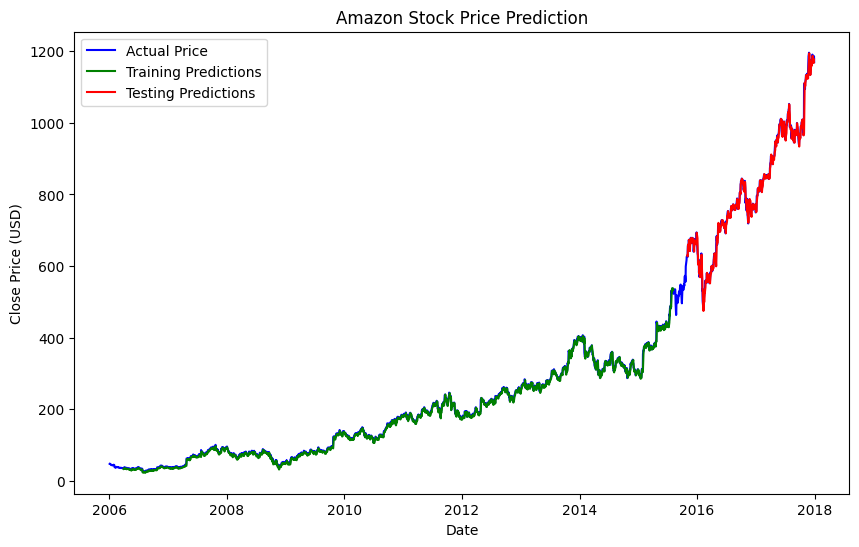

In [14]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(close_data.index, close_data['Close'], label='Actual Price', color='b')
plt.plot(close_data.index[time_step:time_step+len(train_predict)], train_predict, label='Training Predictions', color='g')
plt.plot(close_data.index[train_size+time_step:train_size+time_step+len(test_predict)], test_predict, label='Testing Predictions', color='r')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Amazon Stock Price Prediction')
plt.legend()
plt.show()


In [16]:
import seaborn as sns


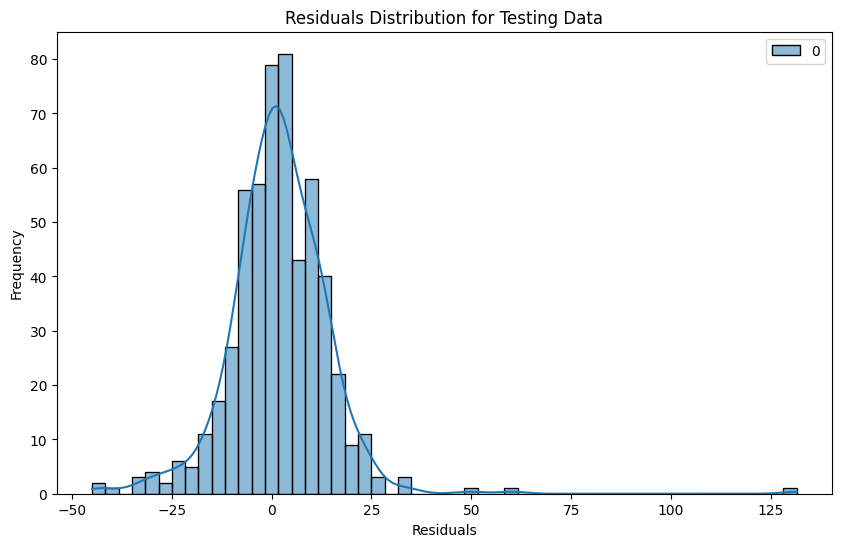

In [17]:
# Residual plot for testing data
residuals = Y_test_actual - test_predict
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Residuals Distribution for Testing Data')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [20]:
# 1-day forecast used as input for subsequent days
forecast_input = test_data[-time_step:]
forecast_input = forecast_input.reshape(1, time_step, 1)

forecast_days = 30
forecast_output = []
for _ in range(forecast_days):
    next_prediction = model.predict(forecast_input, verbose=0)
    forecast_output.append(next_prediction[0, 0])
    forecast_input = np.append(forecast_input[:, 1:, :], next_prediction.reshape(1, 1, 1), axis=1)


In [21]:
# Transform forecast back to original scale
forecast_output = scaler.inverse_transform(np.array(forecast_output).reshape(-1, 1))

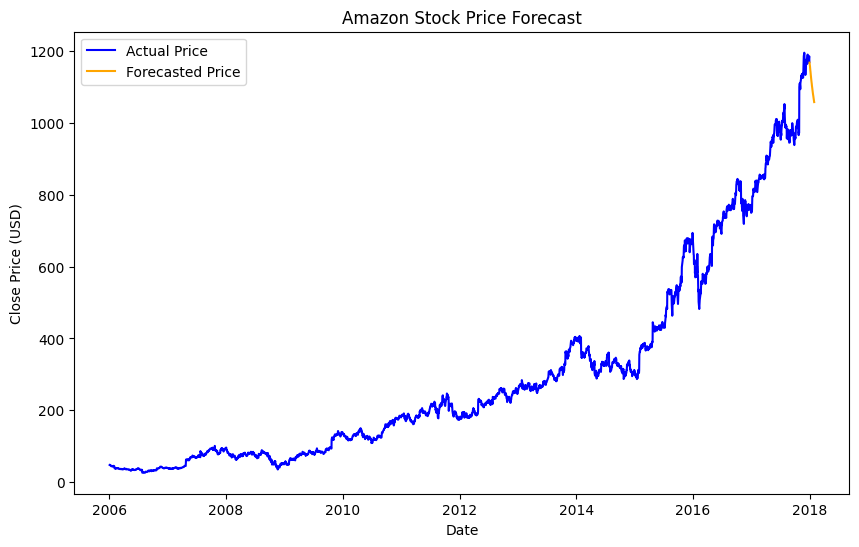

In [22]:
# Plot forecast
forecast_dates = pd.date_range(start=close_data.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
plt.figure(figsize=(10, 6))
plt.plot(close_data.index, close_data['Close'], label='Actual Price', color='b')
plt.plot(forecast_dates, forecast_output, label='Forecasted Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Amazon Stock Price Forecast')
plt.legend()
plt.show()